In [1]:
import numpy as np

import matplotlib.pyplot as plt
import tqdm

import colour
from scipy.spatial import KDTree

import skeletor as sk

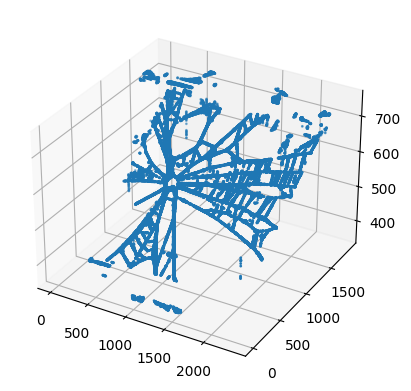

In [2]:
%matplotlib inline
data = 'Data/2d_web_scan.npy'
dsFactor = 1
neighborDistance = 25
np.random.seed(10)

#%matplotlib qt
with open(data, 'rb') as f:
    rawData = np.load(f)
    
order = np.arange(rawData.shape[0])
np.random.shuffle(order)
points = rawData[order][::dsFactor,:]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(points[:,0], points[:,1], points[:,2], s=1)
plt.show()

In [16]:
octree = sk.Octree(points, nBoxes=500, neighborThreshold=1/32, debug=True, neighborMethod='discrete')

centroids = octree.getCentroids()
adjMat = octree.getAdjMat()

Partitioned space into 8x8x8 cells, of which 82 contain points.
Found 84.0 connections.


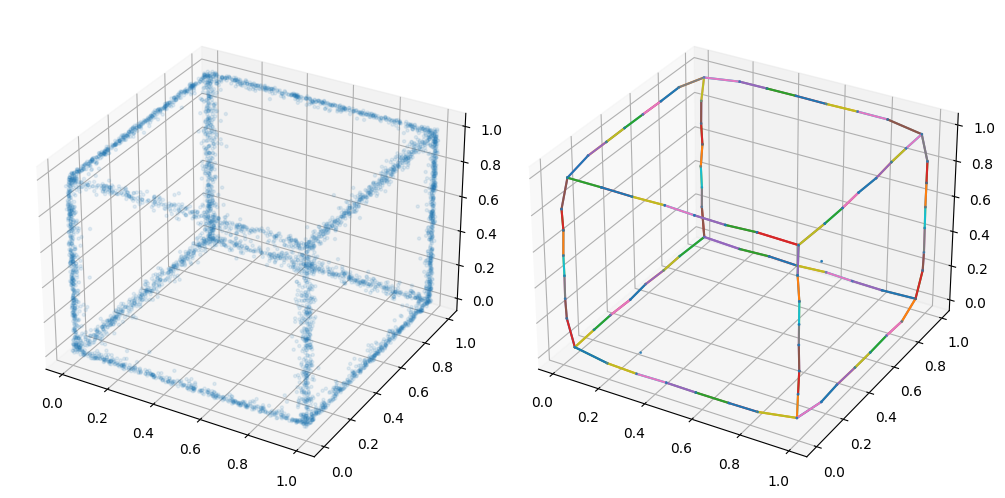

In [17]:
%matplotlib inline

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

ax1.scatter(points[:,0], points[:,1], points[:,2], s=5, alpha=.1)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax2.scatter(centroids[:,0], centroids[:,1], centroids[:,2], s=1)

for i in range(len(adjMat)):
    edgeIndices = np.where(adjMat[i] > 0)[0]
    for j in range(len(edgeIndices)):
        ax2.plot(*list(zip(centroids[i], centroids[edgeIndices[j]])))

fig.tight_layout()
plt.show()

100%|█████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 105.42it/s]


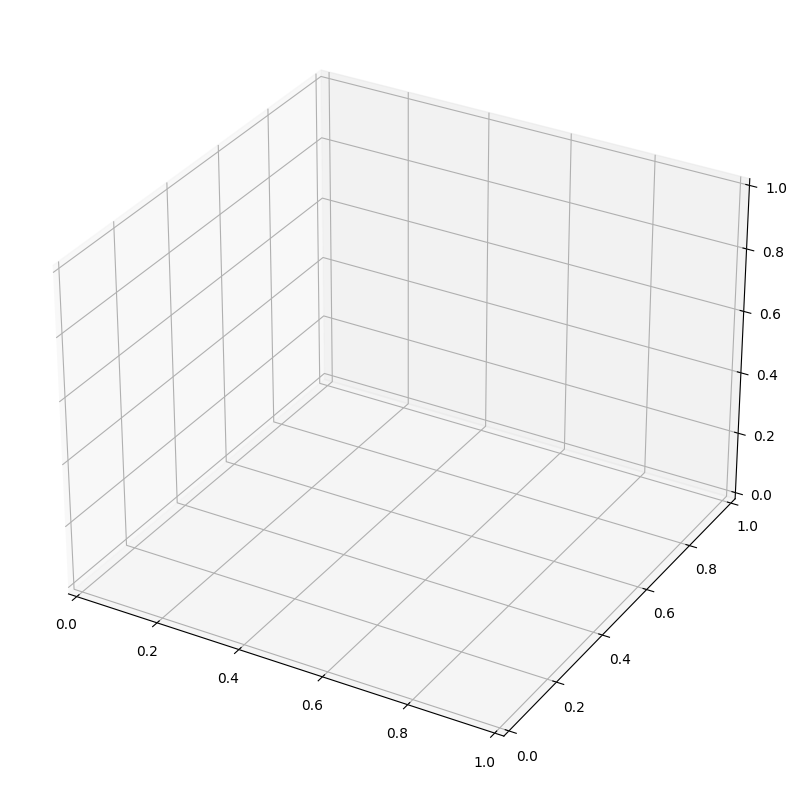

In [11]:
dominantDirections = []
adjMat = octree.getAdjMat()
centroids = octree.getCentroids()

for i in tqdm.tqdm(range(len(centroids))):
    hist, thetaBins, phiBins = sk.angularHistogramAroundPoint(centroids, i, adjMat, smoothing=21)
    peakDirections = sk.findDominantHistogramDirections(hist, thetaBins, phiBins)

    dominantDirections.append(peakDirections)
    
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(projection='3d')

for i in range(len(centroids)):
    for j in range(len(dominantDirections[i])):
        linePoints = np.array([centroids[i], centroids[i] - .1*dominantDirections[i][j]])
        ax.plot(linePoints[:,0], linePoints[:,1], linePoints[:,2], linewidth=3)

plt.show()

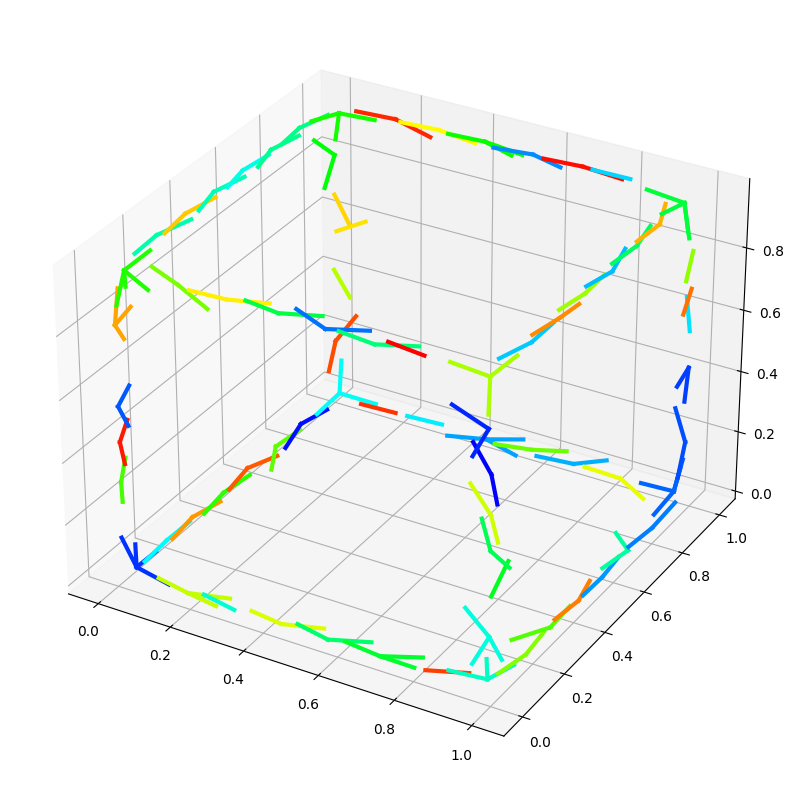

In [22]:
#%matplotlib qt
dominantDirections = [octree.dominantDirections[tuple(ind)] for ind in octree.boxIndices]

fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(projection='3d')

colors = [str(c) for c in colour.Color('Red').range_to('Blue', len(centroids))]

np.random.shuffle(colors)

for i in range(len(centroids)):
    for j in range(len(dominantDirections[i])):
        linePoints = np.array([centroids[i], centroids[i] - .1*dominantDirections[i][j]])
        ax.plot(linePoints[:,0], linePoints[:,1], linePoints[:,2], linewidth=3, c=colors[i])

plt.show()

## Corner Point Testing

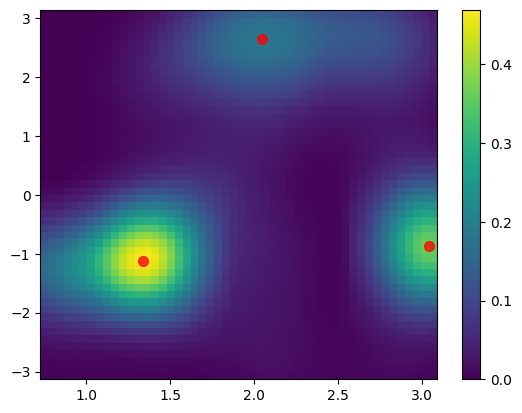

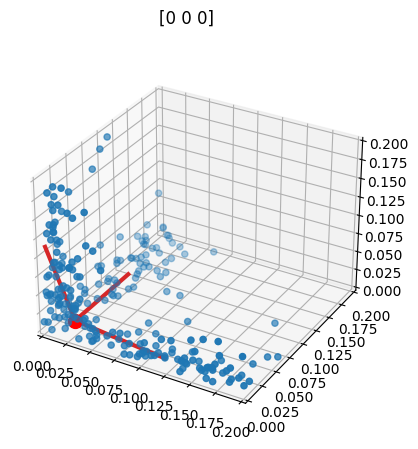

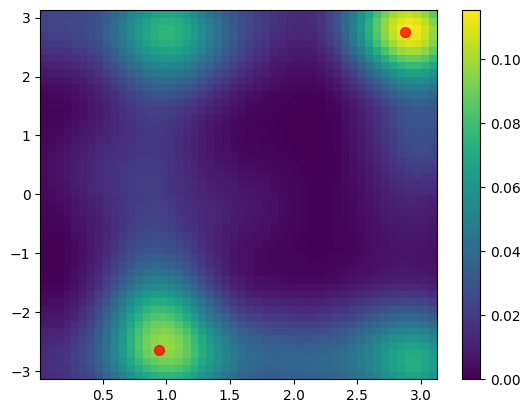

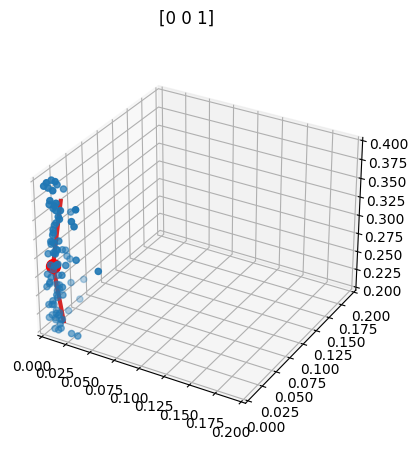

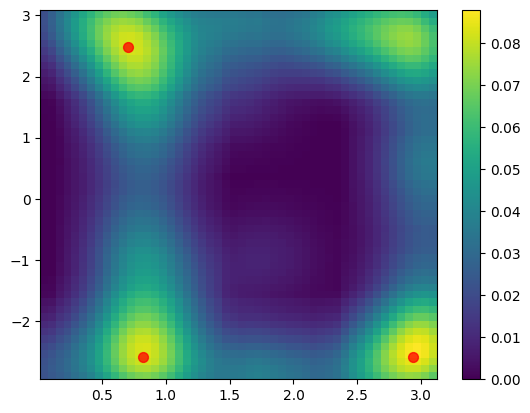

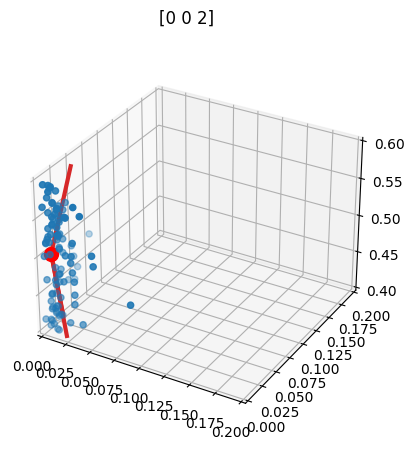

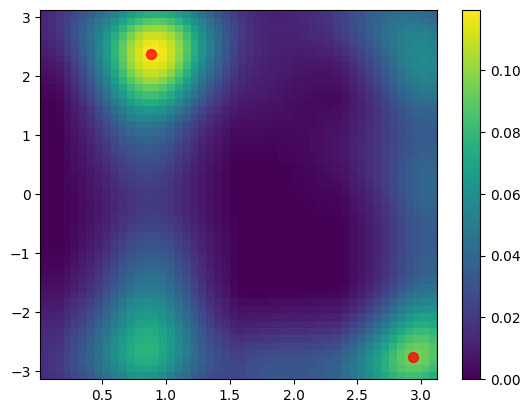

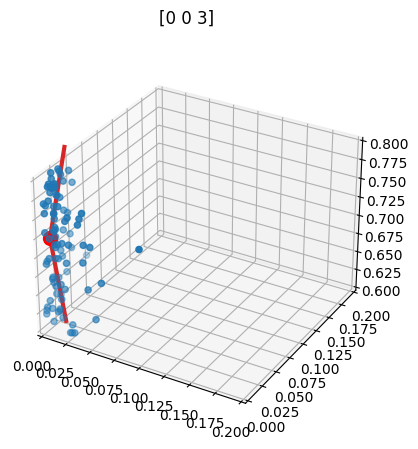

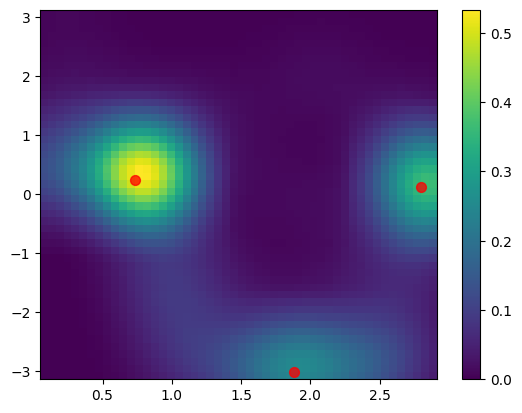

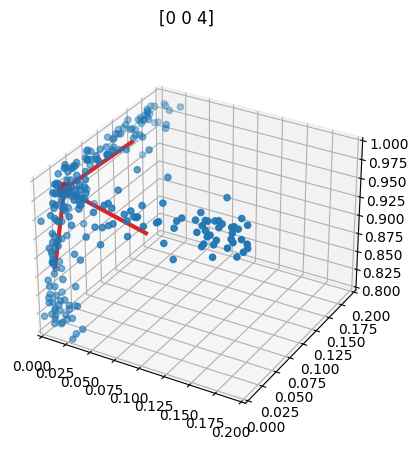

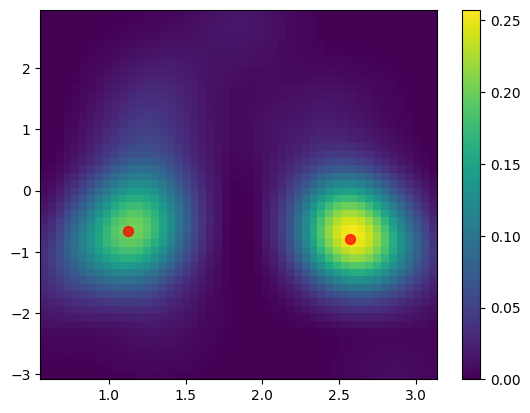

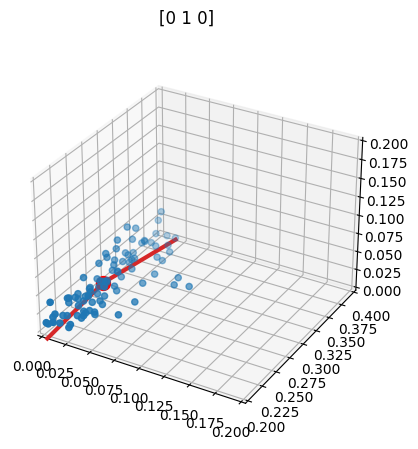

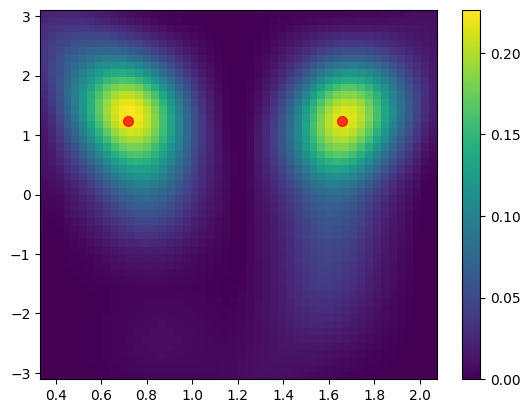

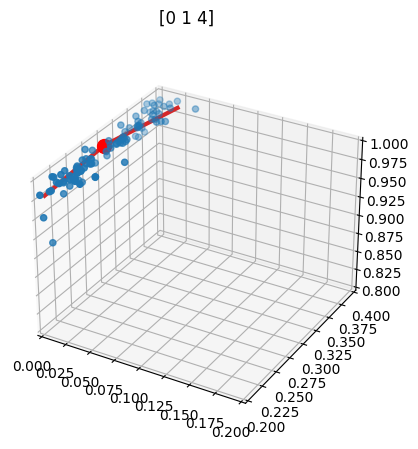

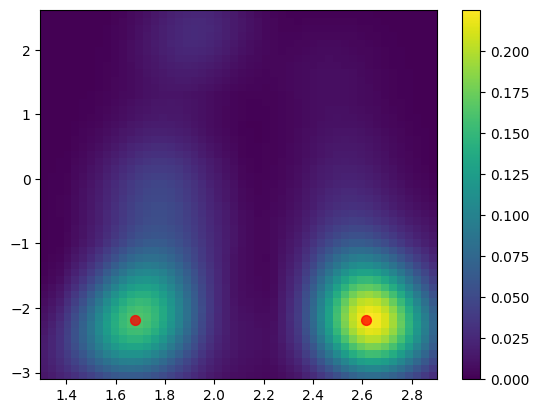

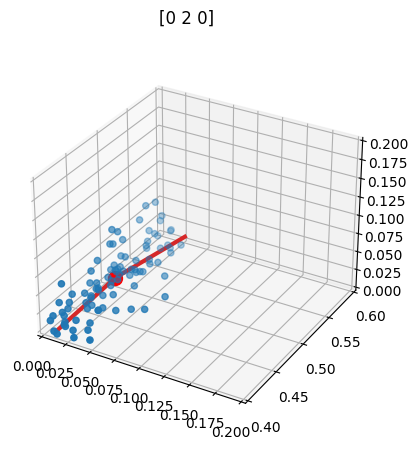

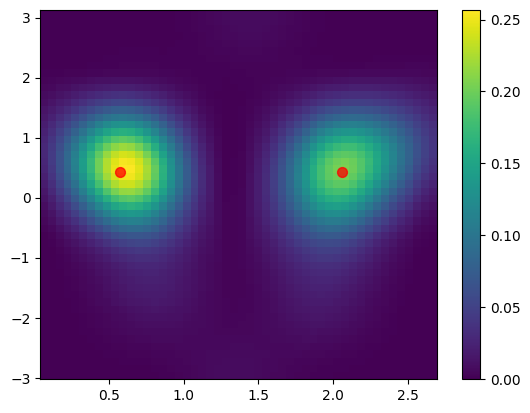

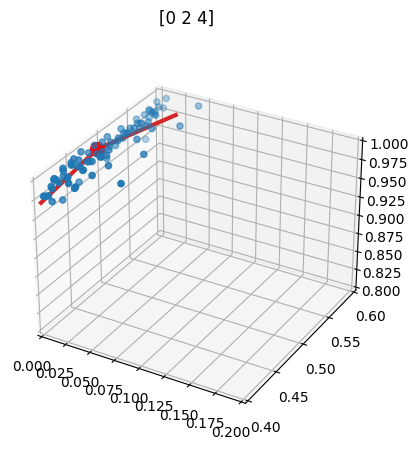

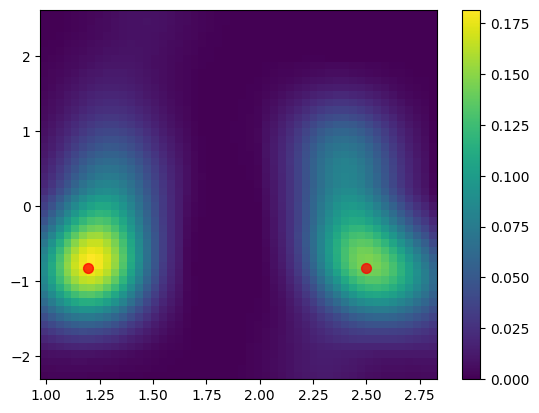

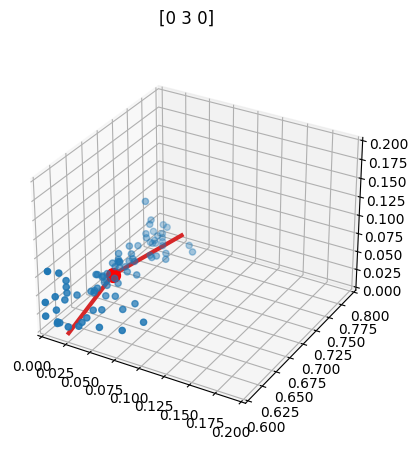

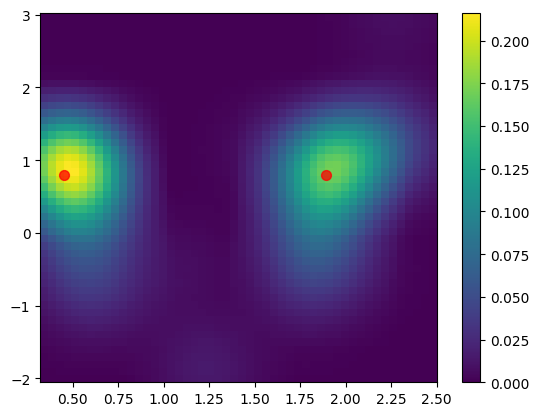

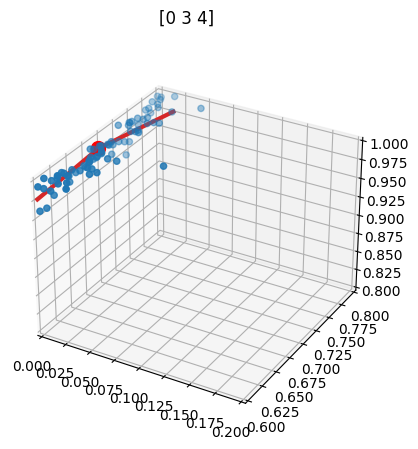

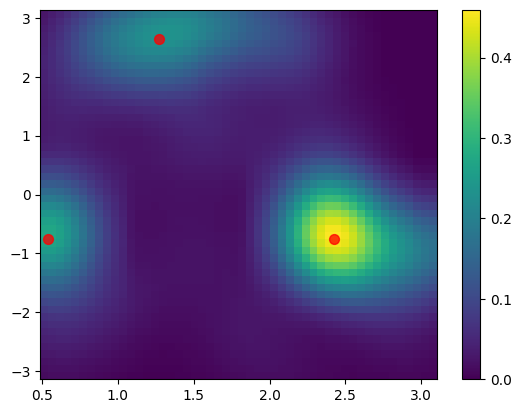

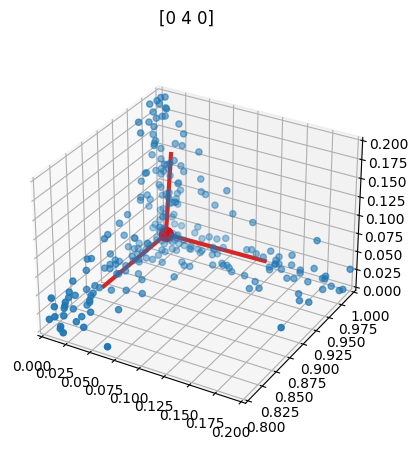

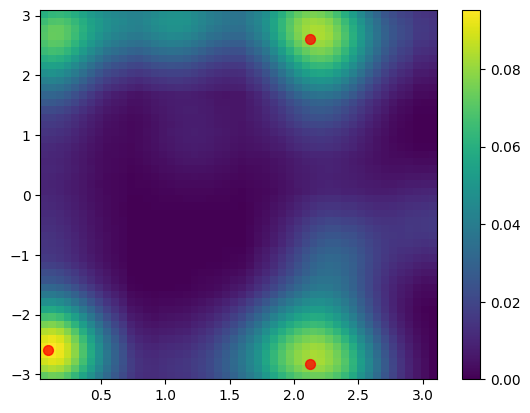

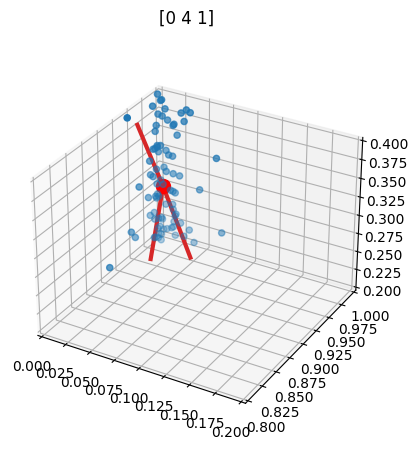

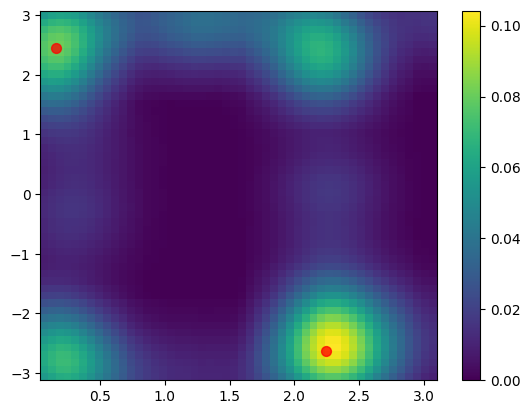

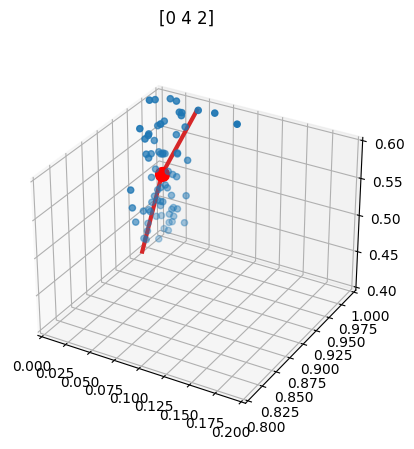

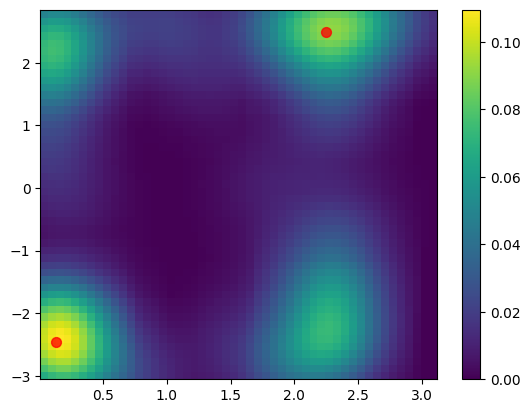

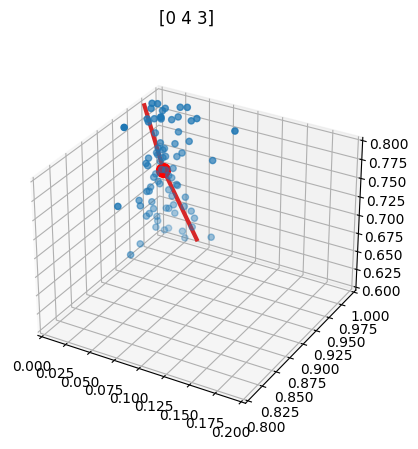

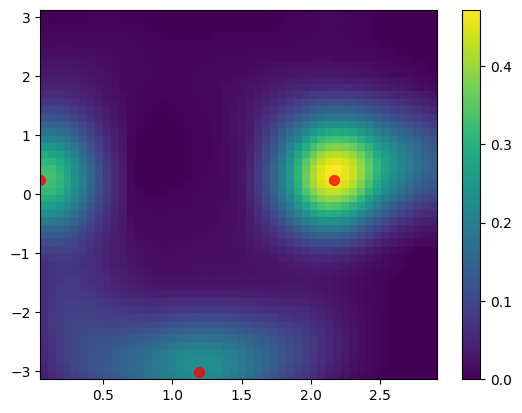

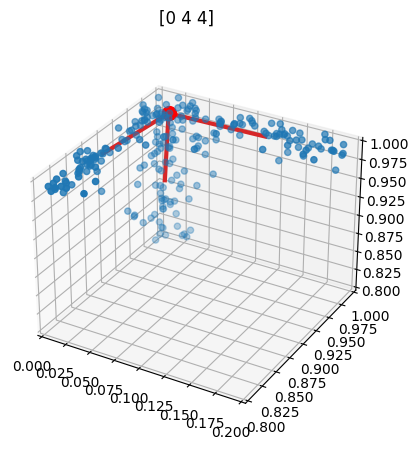

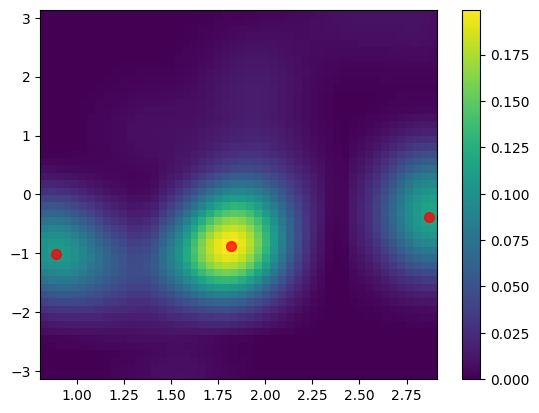

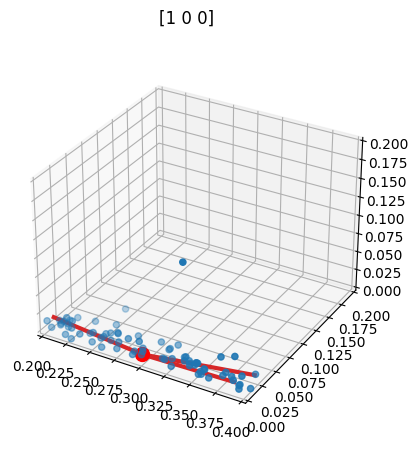

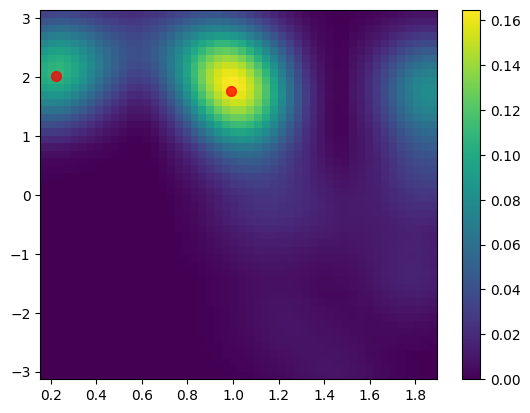

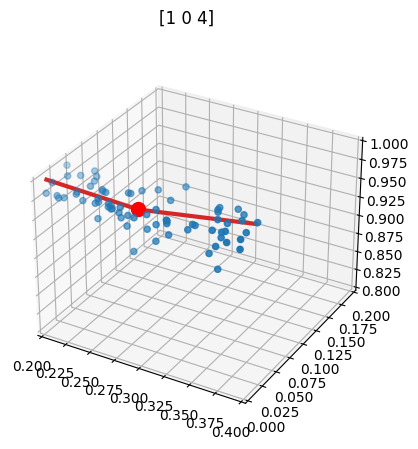

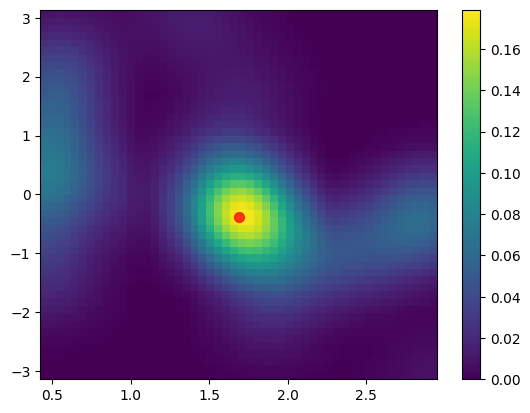

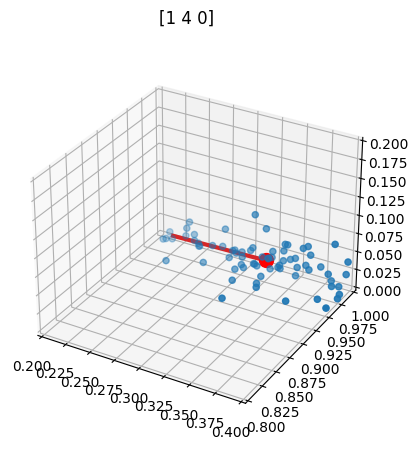

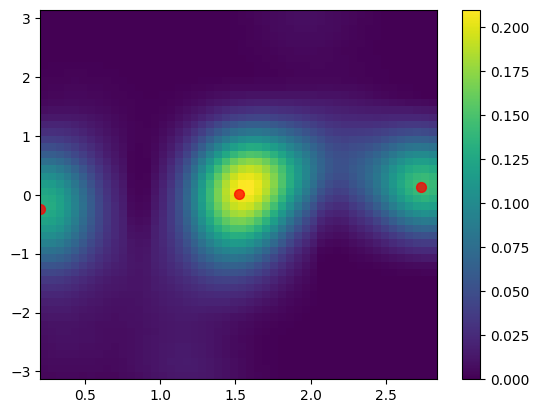

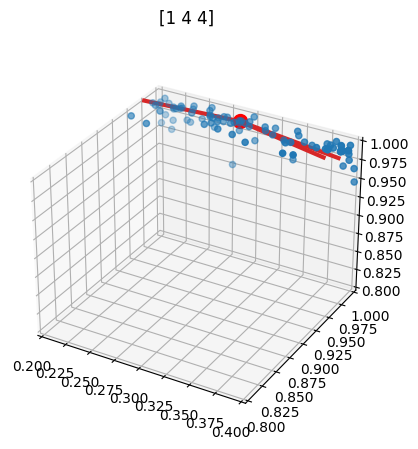

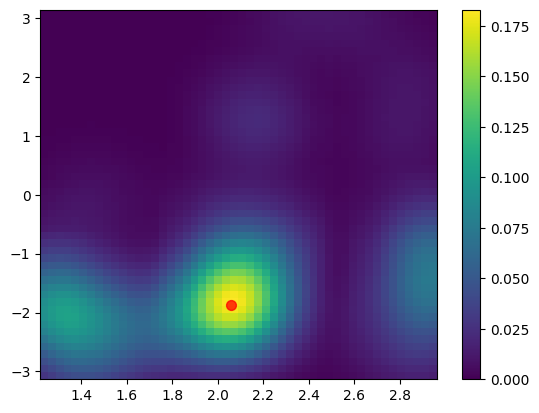

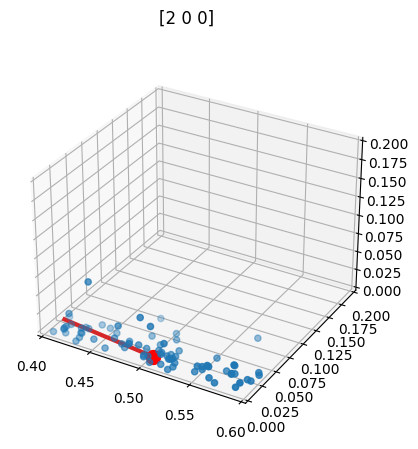

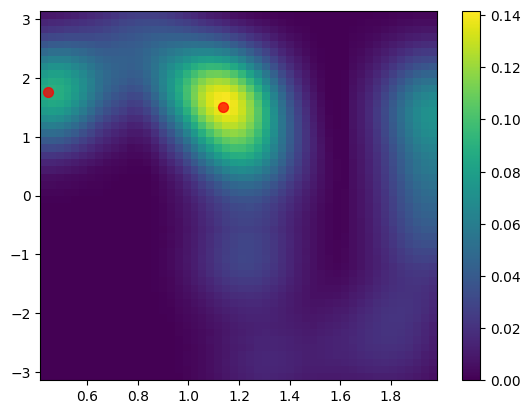

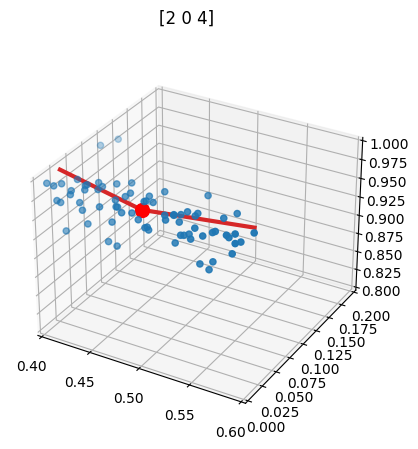

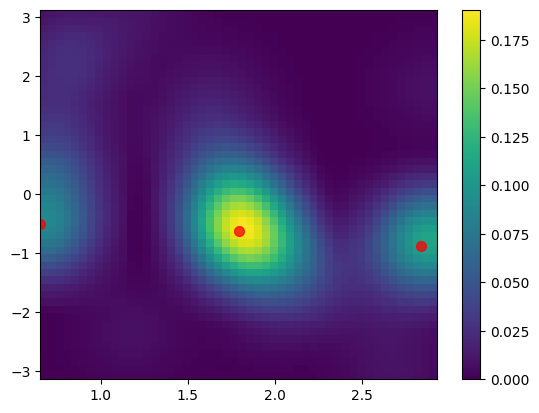

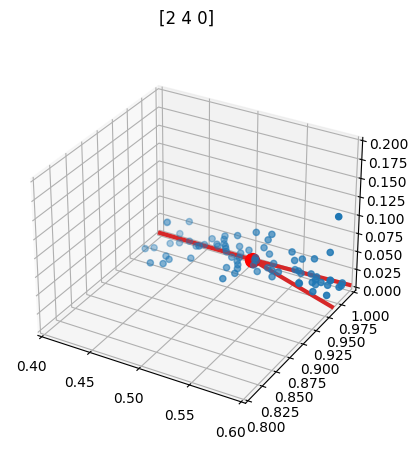

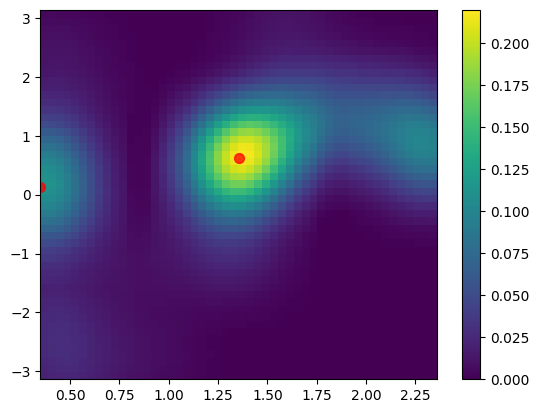

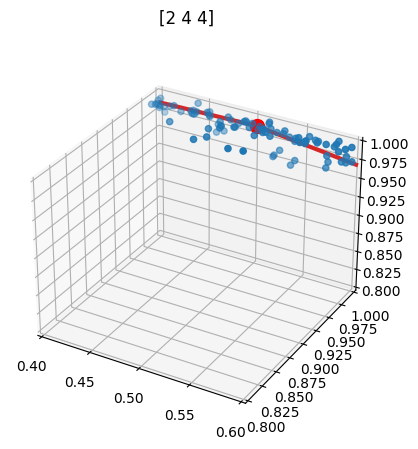

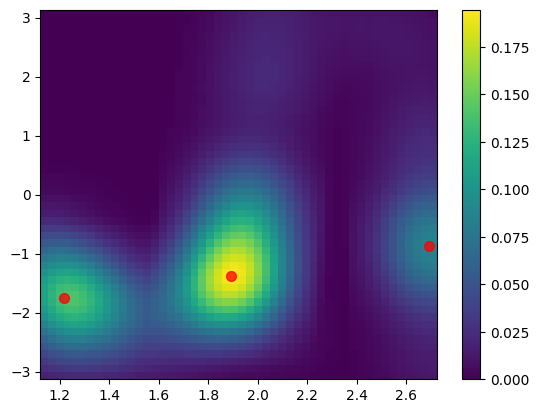

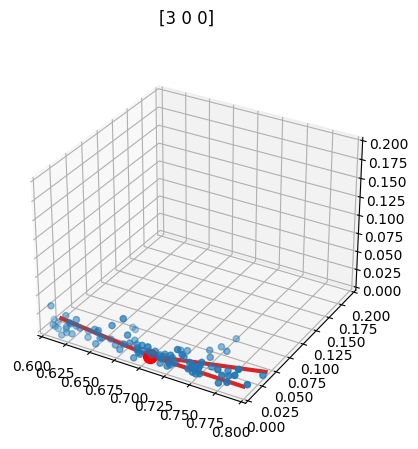

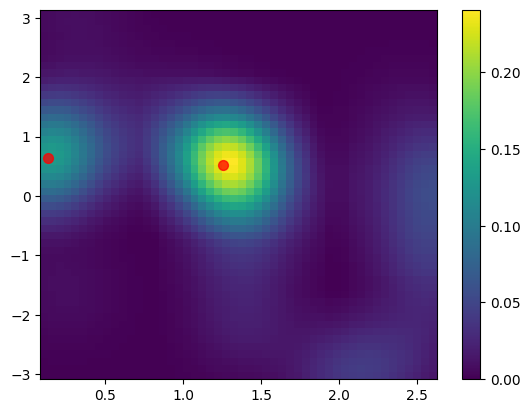

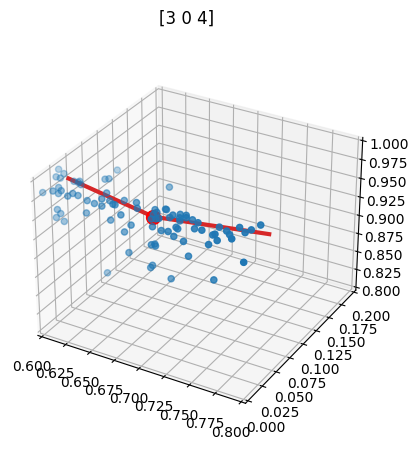

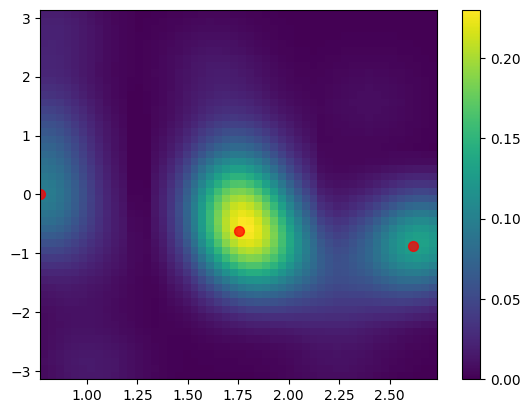

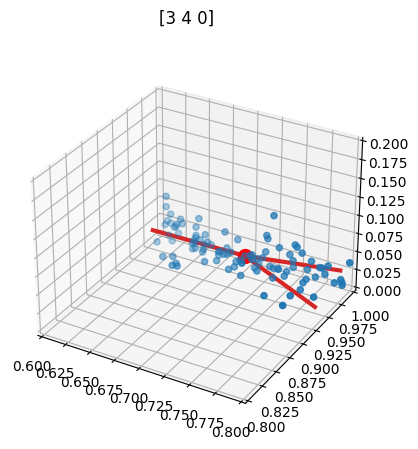

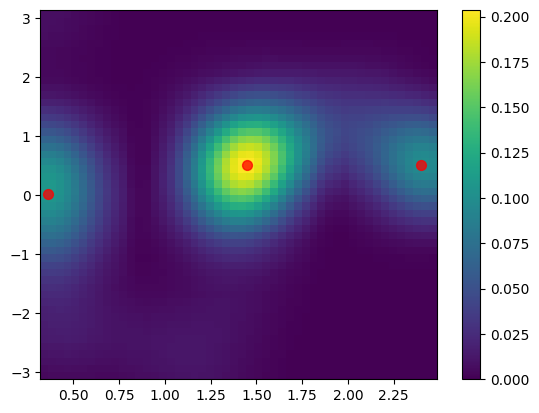

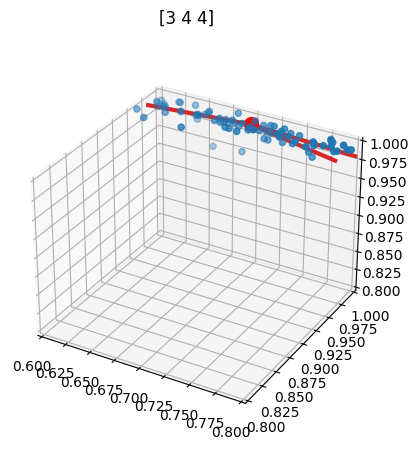

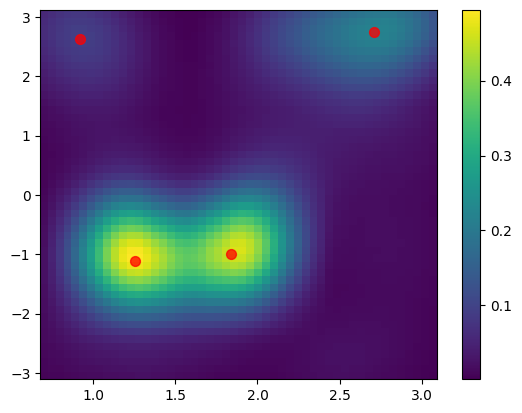

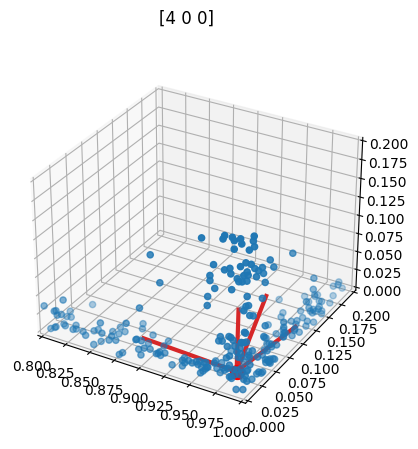

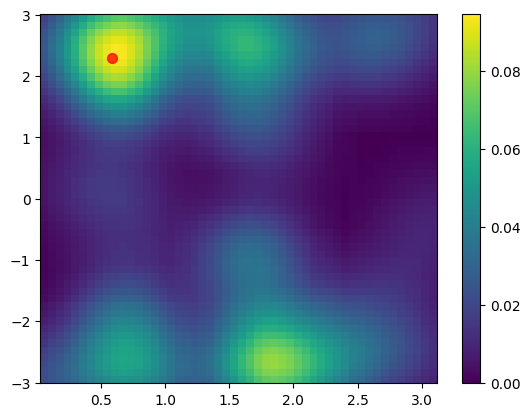

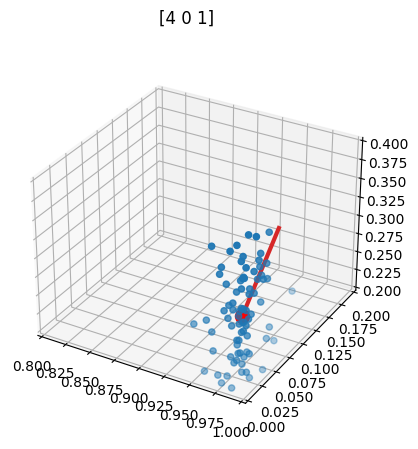

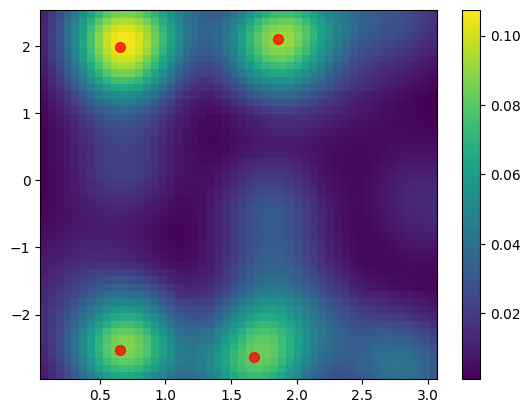

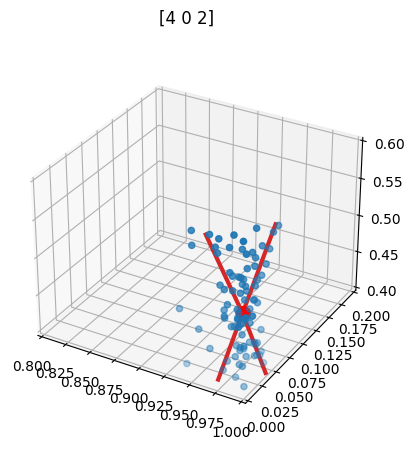

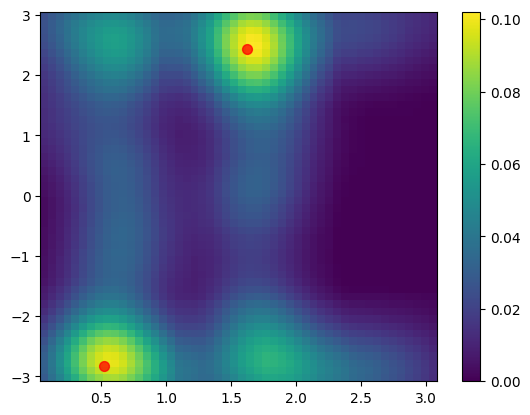

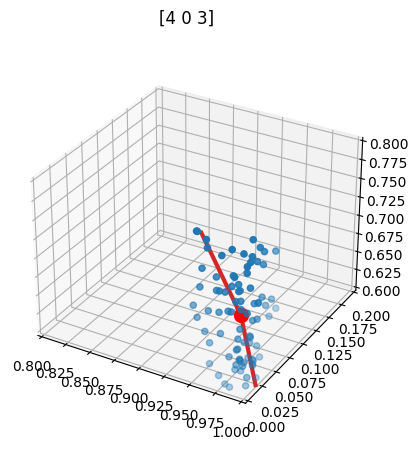

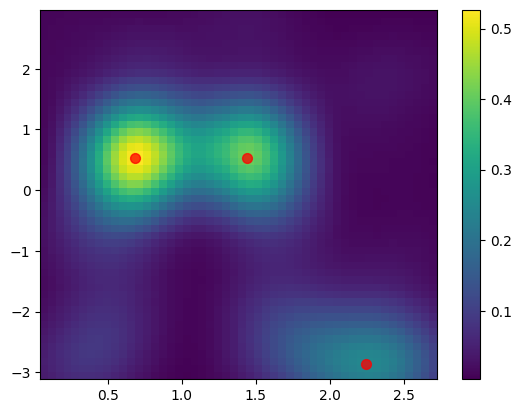

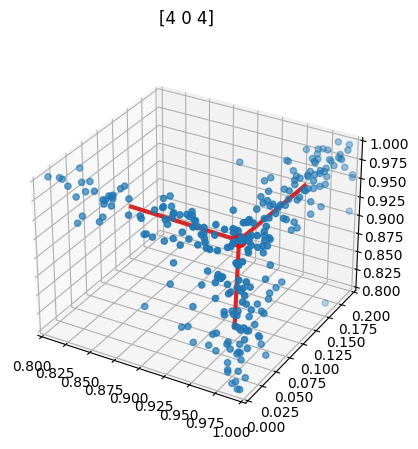

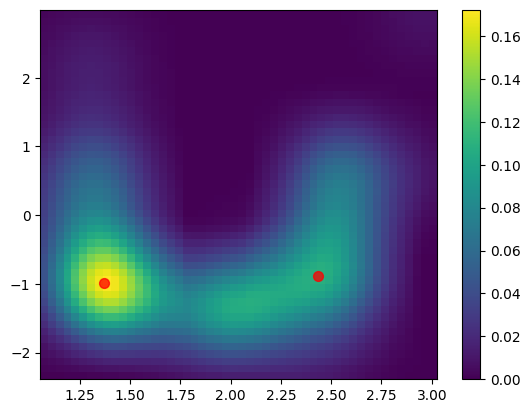

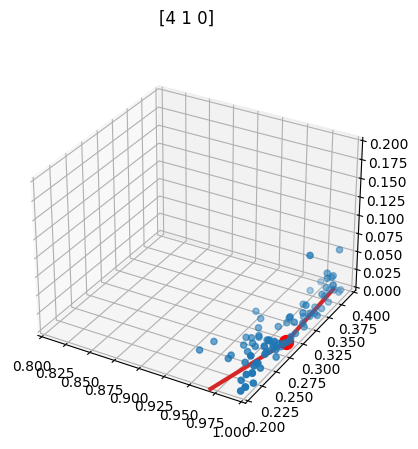

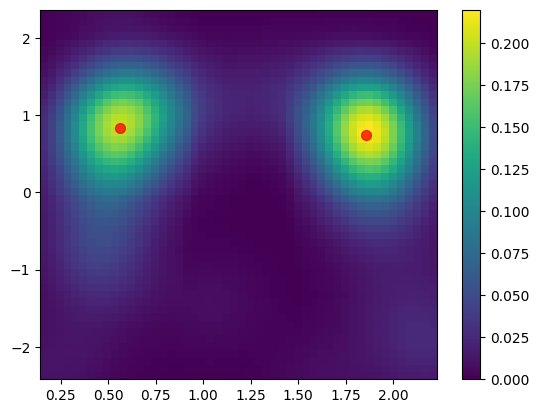

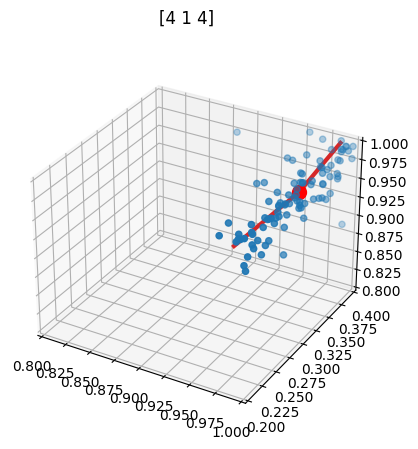

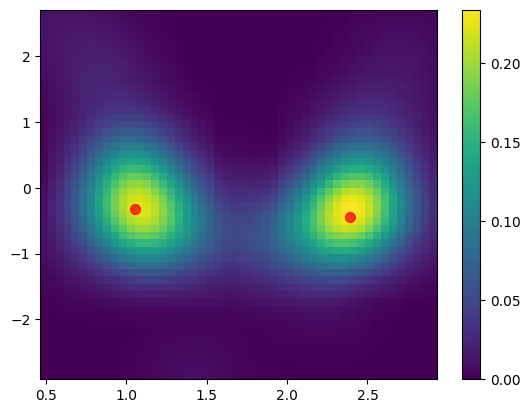

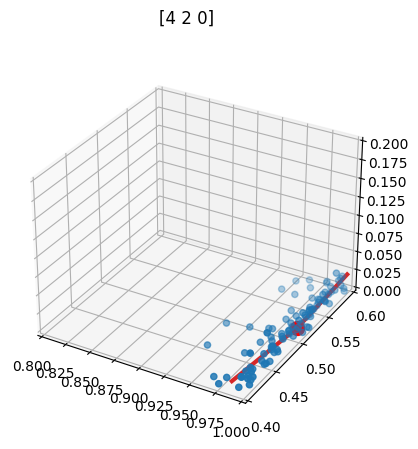

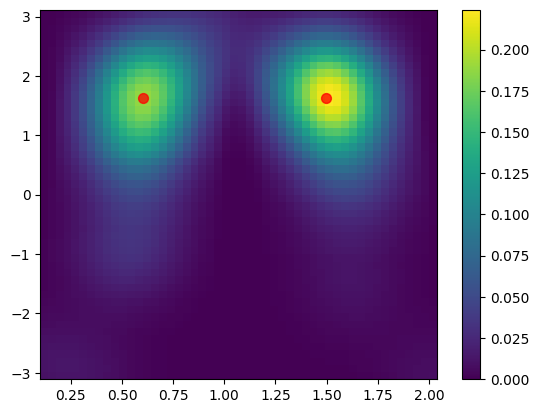

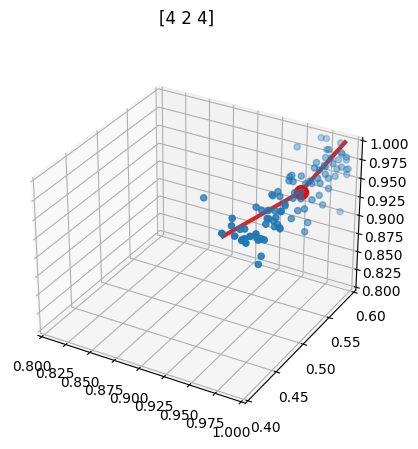

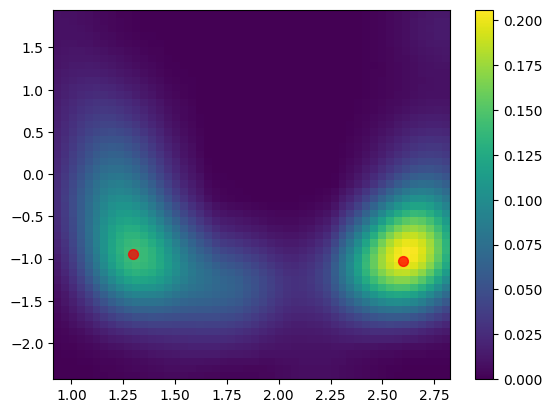

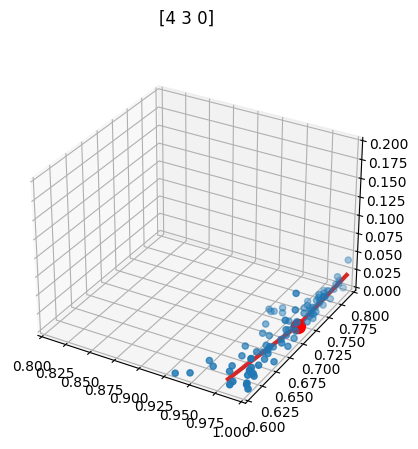

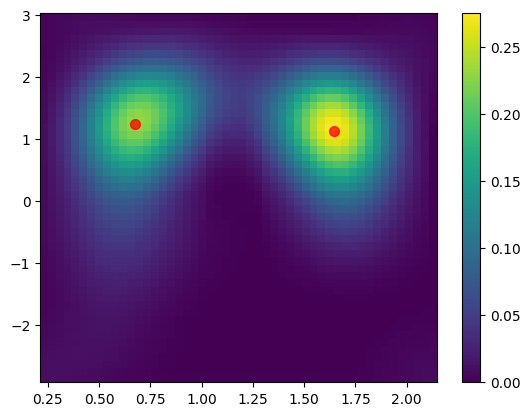

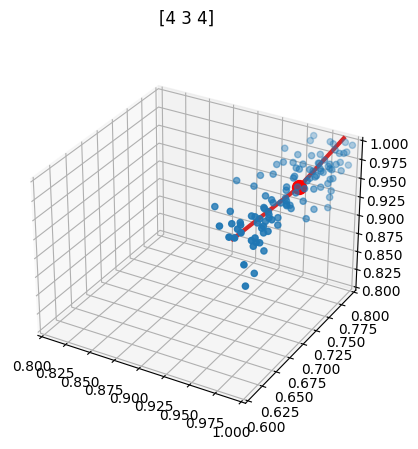

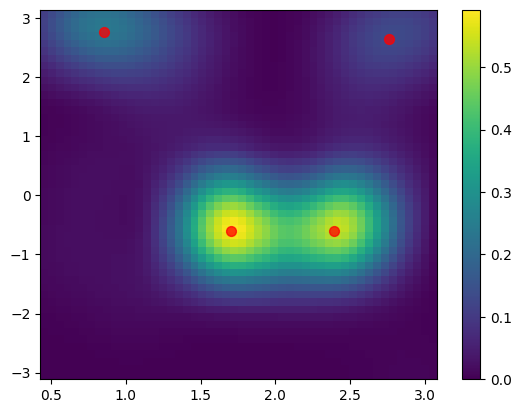

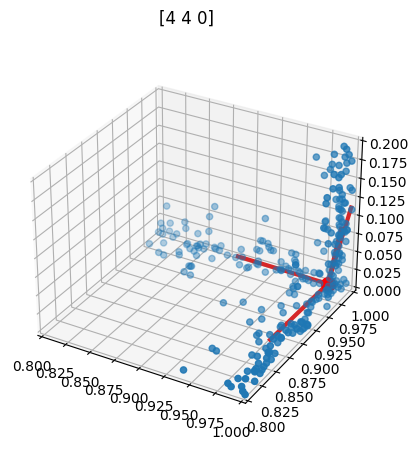

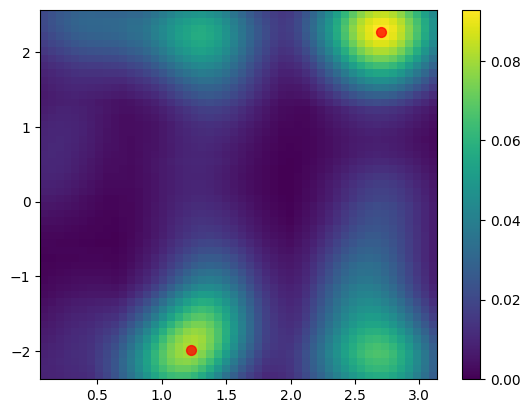

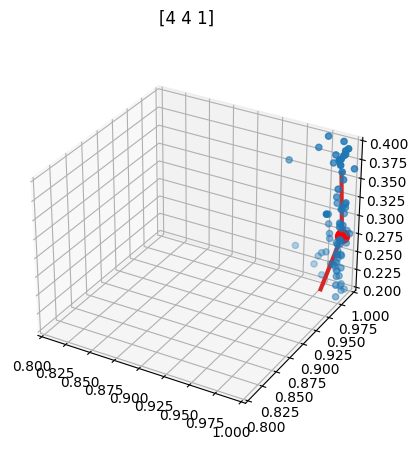

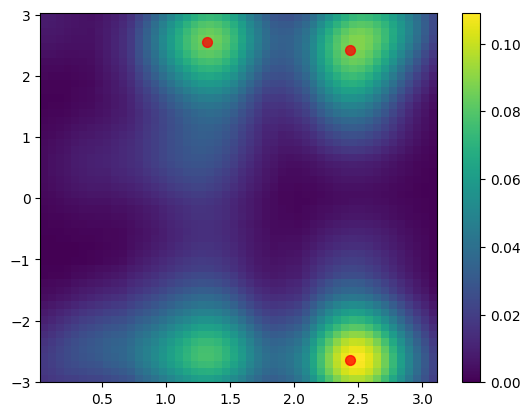

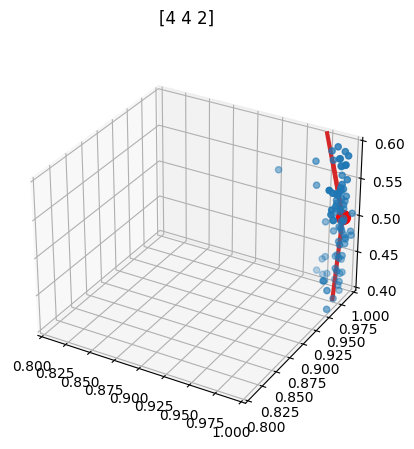

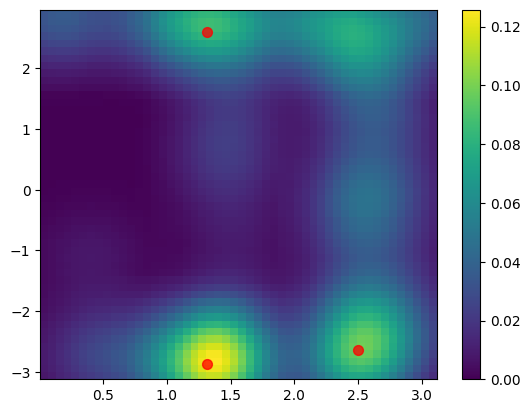

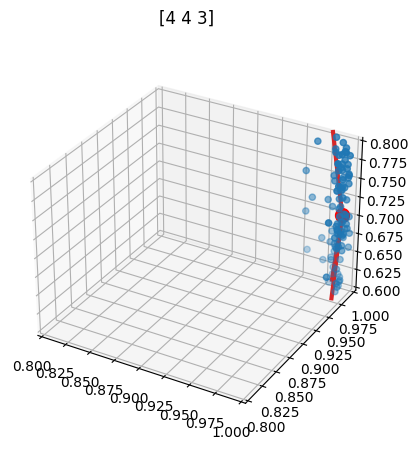

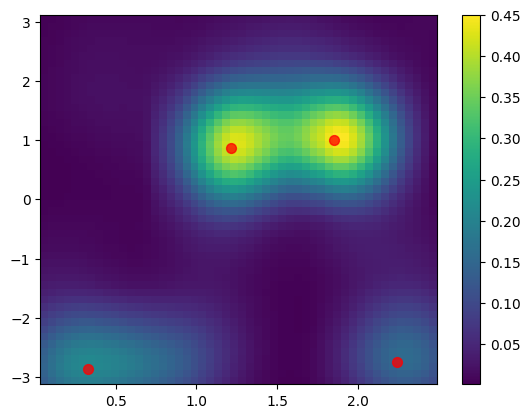

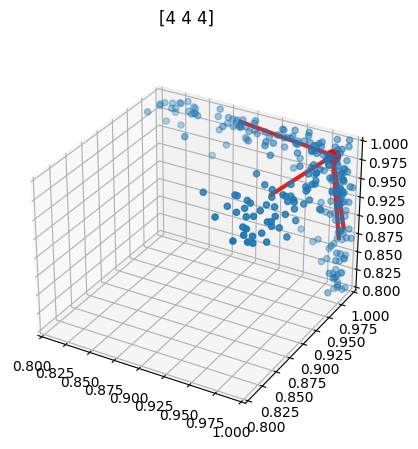

In [20]:
%matplotlib inline
# Grab a point near a corner
boxSize = np.array([.2,.2,.2])

centroidArr = []
peakDirArr = []

boxAllocations = np.array([tuple(t) for t in np.floor(points / boxSize).astype(np.int64)])

for index in np.unique(np.array(boxAllocations), axis=0):
    cornerPoints = points[np.where([not False in b for b in boxAllocations == index])]
    centroid = np.median(cornerPoints, axis=0)
    
    centroidArr.append(centroid)
    
    hist, thetaBins, phiBins = sk.angularHistogramAroundPoint(np.array(list(cornerPoints) + [centroid]), -1, smoothing=21)
    peakDirections = sk.findDominantHistogramDirections(hist, thetaBins, phiBins, .08, debug=True)

    peakDirArr.append(peakDirections)
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(cornerPoints[:,0], cornerPoints[:,1], cornerPoints[:,2])
    ax.scatter(centroid[0], centroid[1], centroid[2], s=100, c='red')

    for j in range(len(peakDirections)):
        linePoints = np.array([centroid, centroid - .1*peakDirections[j]])
        ax.plot(linePoints[:,0], linePoints[:,1], linePoints[:,2], linewidth=3, c='tab:red')

    bounds = [index*boxSize, (index+np.ones(3))*boxSize]
    ax.set_xlim([bounds[0][0], bounds[1][0]])
    ax.set_ylim([bounds[0][1], bounds[1][1]])
    ax.set_zlim([bounds[0][2], bounds[1][2]])

    fig.suptitle(index)
    plt.show()

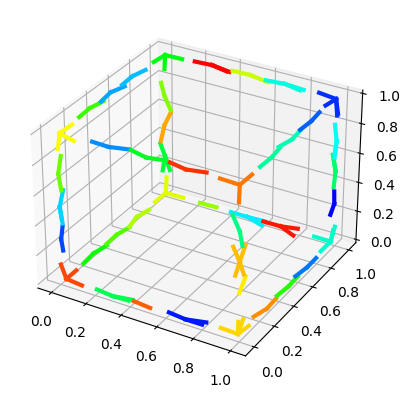

In [21]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(len(centroidArr)):
    for j in range(len(peakDirArr[i])):
        linePoints = np.array([centroidArr[i], centroidArr[i] - .1*peakDirArr[i][j]])
        ax.plot(linePoints[:,0], linePoints[:,1], linePoints[:,2], linewidth=3, c=colors[i])

plt.show()